In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
import numpy as np

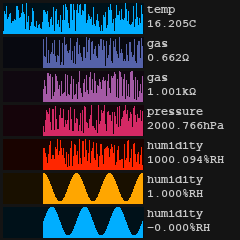

In [3]:
from enum import Enum
from itertools import cycle
from colorsys import rgb_to_hls, hls_to_rgb
from io import BytesIO


FONT_FILE="/usr/share/fonts/truetype/freefont/FreeMonoBold.ttf"

def lighten_darken_color(rgb, factor=0.5):
    r,g,b=rgb
    h,l,s = rgb_to_hls(r/255.0,g/255.0,b/255.0)
    
    if factor<=0:
        l=(1+factor)*l
    else:
        l=1 - factor * (1 - l)
    
    nr,ng,nb= hls_to_rgb(h, l, s)
    
    return int(nr*255),int(ng*255),int(nb*255)


def set_lightness(r,g,b,l):
    h, _, s = rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)
    nr, ng, nb = hls_to_rgb(h, l, s)

    return int(nr * 255), int(ng * 255), int(nb * 255)


class Units(Enum):
    temp="C"
    ohms="\u03a9"
    pressure="hPa"
    humidity="%RH"

class SensorFormats(Enum):
    temp="{x:.3f}"+Units.temp.value
    ohms=u"{x:.3f}"+Units.ohms.value
    kohms=u"{x:.3f}k"+Units.ohms.value
    pressure="{x:.3f}"+Units.pressure.value
    humidity="{x:.3f}"+Units.humidity.value
    
    
class GraphColors(Enum):
    c1=set_lightness(0, 63, 92,0.5)
    c2=set_lightness(68, 78, 134,0.5)
    c3=set_lightness(149, 81, 150,0.5)
    c4=set_lightness(221, 81, 130,0.5)
    c5=set_lightness(255, 110, 84,0.5)
    c6=set_lightness(255, 166, 0,0.5)
    
    
def format_value(value,unit):
    unit_str=unit.value
    
    if unit==Units.ohms and value>1000:
        unit_str="k"+unit_str
        value/=1000.0
        
    return f"{value:.3f}{unit_str}"


def draw_sensors(
    sensors, 
    bg_color=(20, 20, 20), 
    graph_dims=(140,30), 
    spacing=4,
    image_dims=(240,240), 
    light_dark_factor=-0.9,
    dpi=96,
    font_size=12,
    text_color=(200,200,200)
):
    startx,starty=spacing-1,spacing-1
    graphw,graphh=graph_dims
    colors=cycle(GraphColors)
    
    font = ImageFont.truetype(FONT_FILE,size=font_size)
    
    pilim=Image.new("RGB", image_dims, bg_color)
    draw = ImageDraw.Draw(pilim)
    
    for name, unit, values in sensors:
        col=next(colors).value
        bgcol=lighten_darken_color(col,light_dark_factor)
        last_val=0
        
        graph_vals=np.full(graphw,np.nan,np.float32)
        
        num_vals=min(graphw,len(values))
        if num_vals>0:
            sel_values=np.asarray(values[-num_vals:])
            graph_vals[-num_vals:]=sel_values      
            minv=sel_values.min()
            maxv=sel_values.max()
            diff=(maxv-minv) or 1.0
        else:
            minv=maxv=0.0
            diff=1.0
            
        text_pos=(startx+graphw+spacing,starty)
        text=f"{name}\n{format_value(graph_vals[-1],unit)}"
        
        draw.rectangle([(startx,starty),(startx+graphw,starty+graphh)],fill=bgcol)
        draw.multiline_text(text_pos, text, font=font,fill=text_color)

        for x in range(graphw):
            if np.isnan(graph_vals[x]):
                continue
                
            y=(graph_vals[x]-minv)/diff
            indy=starty+int((1-y)*(graphh-1))
            indx=startx+x
            
            if 0<=indy<image_dims[0] and 0<=indx<image_dims[1]:
                draw.line([(indx,indy),(indx,starty+graphh)],fill=col)

        starty+=graphh+spacing
        
    return pilim

sensors=[
    ("temp",Units.temp,np.random.rand(180)*10+10),
    ("gas",Units.ohms,np.random.rand(100)),
    ("gas",Units.ohms,np.random.rand(100)+1000),
    ("pressure",Units.pressure,np.random.rand(100)+2000),
    ("humidity",Units.humidity,np.random.rand(100)+1000),
    ("humidity",Units.humidity,np.cos(np.linspace(0,np.pi*6,100))),
    ("humidity",Units.humidity,np.sin(np.linspace(0,np.pi*6,100)))
]

draw_sensors(sensors)
# plt.figure(figsize=(5,5))
# plt.imshow(data)

In [8]:

from pathlib import Path
from csv import DictWriter

def log_data_csv(filename,values):
    path=Path(filename)
    exists=path.exists()
    
    with open(str(path),"a") as o:
        w=DictWriter(o, tuple(values))
        if not exists:
            w.writeheader()
            
        w.writerow(values)
            
# dat=col.collect()
# log_data_csv("test.csv",dat)

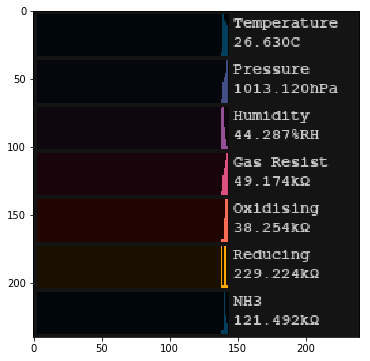

In [35]:
from IPython.display import clear_output
import mics6814 
import bme680
import ST7789
import time
import datetime
from collections import OrderedDict

try:
    env_sensor = bme680.BME680(bme680.I2C_ADDR_PRIMARY)
except (RuntimeError, IOError):
    env_sensor = bme680.BME680(bme680.I2C_ADDR_SECONDARY)

gas_sensor = mics6814.MICS6814()
gas_sensor.set_brightness(0)
gas_sensor.set_led(0,0,0)

env_sensor.set_humidity_oversample(bme680.OS_2X)
env_sensor.set_pressure_oversample(bme680.OS_4X)
env_sensor.set_temperature_oversample(bme680.OS_8X)
env_sensor.set_filter(bme680.FILTER_SIZE_3)
env_sensor.set_gas_status(bme680.ENABLE_GAS_MEAS)
env_sensor.set_gas_heater_temperature(320)
env_sensor.set_gas_heater_duration(150)
env_sensor.select_gas_heater_profile(0)


disp = ST7789.ST7789(
    port=0,
    cs=ST7789.BG_SPI_CS_FRONT,  # BG_SPI_CS_BACK or BG_SPI_CS_FRONT
    dc=9,
    backlight=19,               # 18 for back BG slot, 19 for front BG slot.
    spi_speed_hz=80 * 1000 * 1000,
    offset_left=0
)

disp.begin()

def collect_data(timeout=5,sleep_time=0.01):
    """Collect values from sensors and return as a dictionary."""
    env_ready=env_sensor.get_sensor_data()

    while timeout>0 and (not env_ready or not env_sensor.data.heat_stable):
        time.sleep(sleep_time)
        env_ready=env_sensor.get_sensor_data()
        timeout-=1

    if timeout==0:
        if not env_ready:
            raise IOError("Cannot acquire BME680 data")
        elif not env_sensor.data.heat_stable:
            raise IOError("BME680 heat not stable")

    return OrderedDict(
        time=str(datetime.datetime.now()),
        temperature=env_sensor.data.temperature,
        pressure=env_sensor.data.pressure,
        humidity=env_sensor.data.humidity,
        gas_resistance=env_sensor.data.gas_resistance,
        oxidising= gas_sensor.read_oxidising(),
        reducing= gas_sensor.read_reducing(),
        nh3= gas_sensor.read_nh3(),
    )


def update_arrays(array_dict,data_dict):
    if len(array_dict)==0:
        for k,v in data_dict.items():
            array_dict[k]=[v]
    else:
        for k,v in data_dict.items():
            array_dict[k].append(v)

array_dict=OrderedDict()

for i in range(5):
    dat=collect_data()
    update_arrays(array_dict,dat)
    
    log_data_csv("sensors.csv",dat)
    
    draw_values=(
        ("Temperature",Units.temp,array_dict["temperature"]),
        ("Pressure",Units.pressure,array_dict["pressure"]),
        ("Humidity",Units.humidity,array_dict["humidity"]),
        ("Gas Resist",Units.ohms,array_dict["gas_resistance"]),
        ("Oxidising",Units.ohms,array_dict["oxidising"]),
        ("Reducing",Units.ohms,array_dict["reducing"]),
        ("NH3",Units.ohms,array_dict["nh3"]),
    )

    im=draw_sensors(draw_values)
    
    plt.figure(figsize=(6,6))
    clear_output(wait=True)
    plt.imshow(im)
    plt.show()
    
    disp.display(im)
    
    time.sleep(1)

---

In [ ]:
import mics6814 
import bme680
import time
from collections import OrderedDict

class DataCollector:
    def __init__(self):

        try:
            self.env_sensor = bme680.BME680(bme680.I2C_ADDR_PRIMARY)
        except (RuntimeError, IOError):
            self.env_sensor = bme680.BME680(bme680.I2C_ADDR_SECONDARY)

        self.gas_sensor = mics6814.MICS6814()
        self.gas_sensor.set_brightness(0)
        self.gas_sensor.set_led(0,0,0)

        self.env_sensor.set_humidity_oversample(bme680.OS_2X)
        self.env_sensor.set_pressure_oversample(bme680.OS_4X)
        self.env_sensor.set_temperature_oversample(bme680.OS_8X)
        self.env_sensor.set_filter(bme680.FILTER_SIZE_3)
        self.env_sensor.set_gas_status(bme680.ENABLE_GAS_MEAS)
        self.env_sensor.set_gas_heater_temperature(320)
        self.env_sensor.set_gas_heater_duration(150)
        self.env_sensor.select_gas_heater_profile(0)
        
        self._units=(
            Units.temp, Units.pressure, Units.humidity, Units.ohms, Units.ohms, Units.ohms, Units.ohms
        )
        
    @property
    def units(self):
        """Get the units of the values returned by collect()."""
        return self._units
        
    def collect(self,timeout=5,sleep_time=0.01):
        """Collect values from sensors and return as a dictionary."""
        env_ready=self.env_sensor.get_sensor_data()
        
        while timeout>0 and (not env_ready or not self.env_sensor.data.heat_stable):
            time.sleep(sleep_time)
            env_ready=self.env_sensor.get_sensor_data()
            timeout-=1
            
        if timeout==0:
            if not env_ready:
                raise IOError("Cannot acquire BME680 data")
            elif not self.env_sensor.data.heat_stable:
                raise IOError("BME680 heat not stable")
                
        return OrderedDict(
            temperature=self.env_sensor.data.temperature,
            pressure=self.env_sensor.data.pressure,
            humidity=self.env_sensor.data.humidity,
            gas_resistance=self.env_sensor.data.gas_resistance,
            oxidising= self.gas_sensor.read_oxidising(),
            reducing= self.gas_sensor.read_reducing(),
            read_nh3= self.gas_sensor.read_nh3(),
        )
    
# print(sensor.data.temperature,sensor.data.pressure,sensor.data.humidity,sensor.data.gas_resistance)

# print(gas.read_oxidising(), gas.read_reducing(), gas.read_nh3())

col=DataCollector()

print(col.collect())

In [ ]:
txt = Image.new("RGBA", (240,240), (50,0,50,255))

# d=ImageDraw.Draw(txt)

# fnt = ImageFont.truetype("FreeMono.ttf", 40)

# d.text((10,10), "Hello",font=fnt, fill=(255,0,0,255))

dpi=96
fig=plt.figure(figsize=(240/dpi,240/dpi),dpi=dpi)
plt.axis("off")
plt.tight_layout()
plt.imshow(txt)
plt.text(0,12,"foo",color="red",fontweight="bold",fontsize=10)
plt.savefig("test.png")

In [ ]:
# Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
from io import BytesIO
buf=BytesIO()
fig.savefig(buf)
buf.seek(0)
Image.open(buf)

In [ ]:
from enum import Enum
from itertools import cycle
from colorsys import rgb_to_hls, hls_to_rgb
from io import BytesIO


FONT_FILE="/usr/share/fonts/truetype/freefont/FreeMono.ttf"

def lighten_color(rgb, factor=0.5):
    r,g,b=rgb
    h,l,s = rgb_to_hls(r/255.0,g/255.0,b/255.0)
    
    nr,ng,nb= hls_to_rgb(h, 1 - factor * (1 - l), s)
    
    return (int(nr*255),int(ng*255),int(nb*255))


class SensorFormats(Enum):
    temp="{x:.3f}C"
    ohms=u"{x:.3f}\u03a9"
    kohms=u"{x:.3f}k\u03a9"
    pressure="{x:.3f}hPa"
    humidity="{x:.3f}%RH"
    
    
class GraphColors(Enum):
    red=(255,0,0)
    green=(0,255,0)
    blue=(0,0,255)
    
    
    
def draw_sensors(sensors, bg_color=(255, 243, 230), start=(5,5), graph_dims=(180,40), spacing=5,image_dims=(240,240), light_factor=0.25,dpi=96,font_size=12):
    im=np.asarray(bg_color,np.uint8)
    im=np.tile(im[None,None],(image_dims[0],image_dims[1],1))
    
    startx,starty=start
    graphw,graphh=graph_dims
    colors=cycle(GraphColors)
    
    for _, values in sensors:
        col=next(colors).value
        im[starty:starty+graphh,startx:startx+graphw]=lighten_color(col,light_factor)
        
        minv=values.min()
        maxv=values.max()
        diff=maxv-minv
        num_vals=min(graphw,len(values))
        
        for x in range(num_vals):
            y=(values[x]-minv)/diff
            im[starty+int((1-y)*graphh),startx+x]=col      
        
        starty+=graph_dims[1]+spacing
        
    starty=0
    
    font = ImageFont.truetype(FONT_FILE,size=font_size)
    
    pilim=Image.fromarray(im)
    draw = ImageDraw.Draw(pilim)
    
    for fstr, values in sensors:
        num_vals=min(graphw,len(values))
        if num_vals==0:
            continue
            
        last_val=values[num_vals-1]
        
        
        draw.text((startx+graphw+spacing,starty+font_size//2), fstr.value.format(x=last_val), font=font,fill=(255,0,0,255))
        starty+=graph_dims[1]+spacing
        
    return np.array(pilim)
        
#     fig=plt.figure(figsize=(image_dims[0]/dpi,image_dims[1]/dpi),dpi=dpi)
#     ax = fig.add_subplot(111)
#     ax.axis("off")
#     ax.imshow(im)

#     for fstr, values in sensors:
#         num_vals=min(graphw,len(values))
#         if num_vals==0:
#             continue
            
#         last_val=values[num_vals-1]
        
#         plt.text(startx+graphw+spacing,starty+font_size+2,fstr.value.format(x=last_val),color="red",fontweight="bold",fontsize=font_size)
#         starty+=graph_dims[1]+spacing
        
#     return None
#     buff=BytesIO()
#     fig.savefig(buff)
#     fig.savefig("test.png")
#     buff.seek(0)
#     data=np.array(Image.open(buff))
    
#     data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
#     data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
#     return data
    
# print(SensorFormats.temp.format(x=12.34))
# print(SensorFormats.kohms.format(x=1.2003456))
sensors=[
    (SensorFormats.temp,np.random.rand(180)*10+10),
    (SensorFormats.ohms,np.random.rand(100)),
    (SensorFormats.pressure,np.random.rand(100)+1000),
    (SensorFormats.humidity,np.random.rand(100)+1000)
]

data=draw_sensors(sensors)
plt.figure(figsize=(10,10))
plt.imshow(data)